### Imports

In [1]:
import pandas as pd
import itertools
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
import multiprocessing
import time
import matplotlib.pyplot as plt
import seaborn as sns

### helper functions

In [2]:
def weighted_median(df):
    weighted_medians = {}
    for col in df.select_dtypes(include='number').columns:
        if col != 'Weight':
            df_sorted = df.sort_values(by=col).reset_index(drop=True)
            total_weight = df_sorted['Weight'].sum()
            cumulative_weight = df_sorted['Weight'].cumsum()
            cutoff_index = np.argmax(cumulative_weight >= total_weight / 2)

            # Check if all weights are equal
            if all(df_sorted['Weight'] == df_sorted['Weight'][0]):
                weighted_median_value = df_sorted[col].median()
            else:
                weighted_median_value = df_sorted.iloc[cutoff_index][col]
            weighted_medians[col] = weighted_median_value
    return pd.Series(weighted_medians)

def weighted_mean(df):
    weighted_means = {}
    for col in df.select_dtypes(include='number').columns:
        if col != 'Weight':
            weighted_mean_value = (df[col] * df['Weight']).sum() / df['Weight'].sum()
            weighted_means[col] = weighted_mean_value
    return pd.Series(weighted_means)


def calculate_linreg_metrics(X, y, intercept):
    model = LinearRegression(fit_intercept=intercept)
    model.fit(X, y)
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    log_mse = np.log(mse)
    scoring = 'neg_mean_squared_error'
    r2 = r2_score(y, predictions)
    cv = KFold(n_splits=min(10, len(y)), shuffle=True, random_state=1982)
    cv_mse = -cross_val_score(model, X, y, cv=cv, scoring=scoring).mean()
    
    # Undo log transformation for obtaining true medians 
    true_y = 10 ** y - 1
    true_predictions = 10 ** predictions - 1
    rel_error = np.round(np.abs((true_y - true_predictions) / true_y).mean() * 100, 2)
    
    return log_mse, r2, cv_mse, rel_error

def process_data(df, sub, y, result_list, intercept):
    X = df.loc[sub].T
    log_mse, r2, cv_mse, rel_err = calculate_linreg_metrics(X, y, intercept)  
    result_list.append({
        'Environments': sub,
        'log_mse': log_mse,
        'r2': r2,
        'cv_mse': cv_mse,
        'rel_error': rel_err,
    })

def game_reg(df, sub, y, result_list, intercept):
    X = df.loc[sub].T
    _, r2, _, _ = calculate_linreg_metrics(X, y, intercept)  
    result_list.append({
        'Environments': y.name,
        'r2': r2
    })

def plot_r2_scores(df, title, fig_name):
    unique_benchmarks = df['Benchmark'].unique()
    palette = {benchmark: 'tab:blue' if benchmark == 'Atari_100k' else 'tab:orange' for benchmark in unique_benchmarks}
    plt.figure(figsize=(10, 2))
    sns.barplot(x='Environments', y='r2', data=df, hue='Benchmark', palette=palette, zorder=3)
    plt.ylim(0, 1)
    #plt.yticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.xticks(rotation=80)
    plt.grid(axis='y', linestyle='-', alpha=0.5, zorder=0)
    plt.xlabel('Games')
    plt.ylabel('R-squared Value')
    plt.title(title)
    # Adjust the legend size and padding
    plt.legend(title='Benchmark', fontsize='small', title_fontsize='medium', handletextpad=0.5, borderpad=0.5)
    plt.savefig(fig_name, format='svg')
    plt.show()

### Dataset

In [3]:
df_original = pd.read_csv('dataset.csv')

##### Base = Random Score 
##### Reference = PPO score at convergence criteria; train atleast until 1m steps and stop training if score does not improve in last 250k steps  
##### Self Trained PPO, A2C, TRPO, Recurrent PPO over 4 seeds using SB3
##### PPO, CURL, Dreamer scores imported from literature 

### Score normalisation using random scores as base and PPO to convergence score as reference

In [4]:
df = df_original

#Filter based on benchmark or action space as needed
#df = df[df['Benchmark'] == 'Atari_100k']        #    Atari_100k       DMC_1m
# df = df[df['Action Space'] == 'Continuous']      #    Discrete         Continuous

columns_to_normalize = df.columns[df.columns.get_loc('Reference') + 1:]  # Get all columns after 'My PPO'
for col in columns_to_normalize:
    base = df["Base"]
    ref = df["Reference"]
    df[col] = np.where(
        (df[col].notnull()) & ((ref - base) != 0),
        100 * ((df[col] - base) / (ref - base)),
        np.nan
    )
df["Base"] = 0.0
df["Reference"] = 100.0

In [5]:
df.head(3)

,Environments,Benchmark,Action Space,Base,Reference,My PPO,A2C,TRPO,R-PPO,PPO,CURL,Dreamer
0,Alien,Atari_100k,Discrete,0.0,100.0,8.679272,18.121402,-2.248795,3.449244,2.255815,15.463097,41.662377
1,Amidar,Atari_100k,Discrete,0.0,100.0,9.782574,10.355499,3.852563,5.421362,1.602920,10.815744,7.236947
2,Assault,Atari_100k,Discrete,0.0,100.0,13.353855,17.230368,1.665560,5.722424,1.336024,4.830634,5.883104


### Apply log transformation on all scores and drop base and reference columns

In [6]:
df = df.drop(columns=['Base', 'Reference'])
score_columns = df.select_dtypes(include=['number']).columns
df[score_columns] = df[score_columns].apply(lambda x: np.log10(1 + np.clip(x, 0, float('inf'))))
df.set_index('Environments', inplace=True)
df = df.rename_axis(None)

In [7]:
df.head(3)

,Benchmark,Action Space,My PPO,A2C,TRPO,R-PPO,PPO,CURL,Dreamer
Alien,Atari_100k,Discrete,0.985843,1.281520,0.000000,0.648286,0.512660,1.216512,1.630045
Amidar,Atari_100k,Discrete,1.032722,1.055206,0.685971,0.807627,0.415461,1.072461,0.915766
Assault,Atari_100k,Discrete,1.156969,1.260795,0.425788,0.827526,0.368477,0.765716,0.837784


### Add weights to games and calculate algo median scores  
Add weights according to the grouping criteria used - benchmark/action space etc.  
Giving equal weight to Atari and Mujoco benchmarks here, so they have equal contribution to the medians. 

In [8]:
envs = df.index.tolist()

benchmarks = df['Benchmark'].value_counts().to_dict()
print("\n")
for key, value in benchmarks.items():
    print(f"{key}: {value} envs")
print(f"Work benchmark: {df.shape[0]} envs\n")
df['Weight'] = 1 / df['Benchmark'].map(benchmarks)

algo_medians_weighted = weighted_median(df)
print(f"Algo medians \n{algo_medians_weighted}")



Atari_100k: 26 envs
DMC_1m: 12 envs
Work benchmark: 38 envs

Algo medians 
My PPO     1.357445
A2C        0.843451
TRPO       1.131850
R-PPO      0.374171
PPO        0.545300
CURL       1.703491
Dreamer    1.951132
dtype: float64


### Individual games scores regressions to predict the median scores of the combined benchmark

intercept set to False

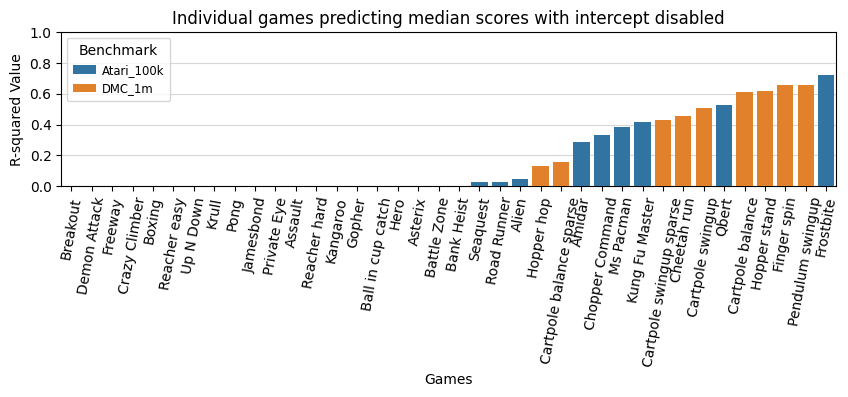

In [9]:
# Regression: X as individual game scores, y as algo medians 
reg_result = []
subsets = [list(subset) for subset in itertools.combinations(envs, 1)]
for game in subsets:
    process_data(df[score_columns], game, algo_medians_weighted, reg_result, intercept=False)

reg_result_df = pd.DataFrame(reg_result)

# Plot environments with increasing R squares
reg_result_df_sorted = reg_result_df.sort_values(by='r2', ascending=True)
reg_result_df_sorted['Environments'] = reg_result_df_sorted['Environments'].apply(lambda x: x[0])
reg_result_df_sorted = pd.merge(reg_result_df_sorted, df_original[['Environments', 'Benchmark']], on='Environments', how='left')
plot_r2_scores(reg_result_df_sorted, "Individual games predicting median scores with intercept disabled", "eval1_intercept_1")

In [10]:
reg_result_df_sorted

,Environments,log_mse,r2,cv_mse,rel_error,Benchmark
0,Breakout,0.001638,-2.419988,1.606834,181.74,Atari_100k
1,Demon Attack,-0.153755,-1.927779,1.249288,249.11,Atari_100k
2,Freeway,-0.254304,-1.647710,0.871254,167.12,Atari_100k
3,Crazy Climber,-0.395564,-1.298911,0.818801,203.62,Atari_100k
4,Boxing,-0.506952,-1.056587,0.977195,94.06,Atari_100k
5,Reacher easy,-0.673939,-0.740305,0.614532,177.17,DMC_1m
6,Up N Down,-0.714472,-0.671176,1.421873,105.66,Atari_100k
7,Krull,-0.722001,-0.658641,0.611582,161.30,Atari_100k
8,Pong,-0.838980,-0.475533,0.540327,171.94,Atari_100k
9,Jamesbond,-0.877850,-0.419280,0.512706,219.60,Atari_100k


Showing all R squared values between 0 and 1.  
Many games show no predictive ability for median scores of the combined benchmark when taken individually.

intercept set to True

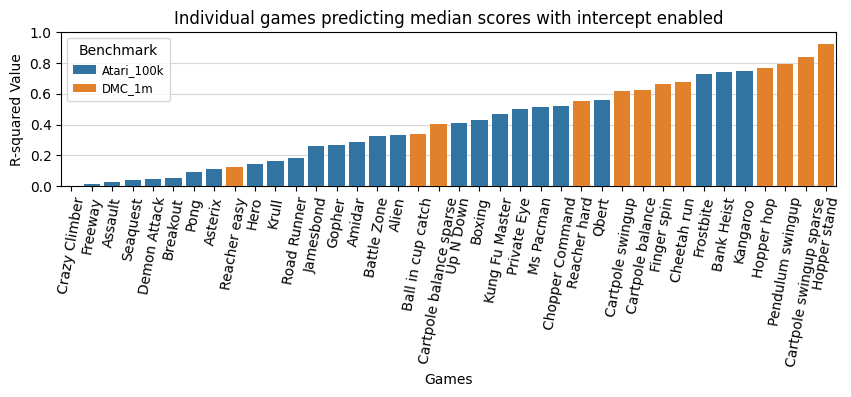

In [11]:
# Regression: X as individual game scores, y as algo medians 
reg_result = []
subsets = [list(subset) for subset in itertools.combinations(envs, 1)]
for game in subsets:
    process_data(df[score_columns], game, algo_medians_weighted, reg_result, intercept=True)

reg_result_df = pd.DataFrame(reg_result)

# Plot environments with increasing R squares
reg_result_df_sorted = reg_result_df.sort_values(by='r2', ascending=True)
reg_result_df_sorted['Environments'] = reg_result_df_sorted['Environments'].apply(lambda x: x[0])
reg_result_df_sorted = pd.merge(reg_result_df_sorted, df_original[['Environments', 'Benchmark']], on='Environments', how='left')
plot_r2_scores(reg_result_df_sorted, "Individual games predicting median scores with intercept enabled", "eval1_intercept_2")

In [12]:
reg_result_df_sorted

,Environments,log_mse,r2,cv_mse,rel_error,Benchmark
0,Crazy Climber,-1.228498,0.000498,0.531884,216.00,Atari_100k
1,Freeway,-1.242297,0.014195,0.626730,216.49,Atari_100k
2,Assault,-1.255054,0.026691,0.492916,212.71,Atari_100k
3,Seaquest,-1.268934,0.040108,0.523424,226.23,Atari_100k
4,Demon Attack,-1.274381,0.045323,0.529471,214.11,Atari_100k
5,Breakout,-1.285323,0.055711,0.428834,214.42,Atari_100k
6,Pong,-1.327118,0.094365,0.477564,214.69,Atari_100k
7,Asterix,-1.344324,0.109813,0.488960,208.43,Atari_100k
8,Reacher easy,-1.358850,0.122651,0.496454,221.47,DMC_1m
9,Hero,-1.386615,0.146675,1.031358,230.86,Atari_100k


### Find the best subset of 3 games, then from that find the best 2, then from that find the best 1. 

In [13]:
best_subsets = {}
previous_best_subset = envs  # Start with all environments

# Iterate through subset sizes
for sub_size in [3, 2, 1]:
    subsets = [list(subset) for subset in itertools.combinations(previous_best_subset, sub_size)]
    manager = multiprocessing.Manager()
    all_results = manager.list()
    start_time = time.time()
    # Multiprocessing to parallelise regressions
    pool = multiprocessing.Pool(processes=24)
    intercept = False # disabled intercept 
    # Regression: X as matrix of algorithm scores for subsets games and y as algorithm median scores 
    pool.starmap(process_data, [(df[score_columns], sub, algo_medians_weighted, all_results, intercept) for sub in subsets])
    pool.close()
    pool.join()
    end_time = time.time()
    all_metrics = list(all_results)

    # Sort by cv_mse, then by r2 (in descending order), then by log_mse
    all_metrics_sorted = sorted(all_metrics, key=lambda x: (x['cv_mse'], -x['r2']))
    best_subset = all_metrics_sorted[0]

    print(f"\nSize: {sub_size}")
    print(f"{', '.join(best_subset['Environments'])}")
    print(f"CV MSE: {best_subset['cv_mse']}")
    print(f"R^2: {best_subset['r2']}")
    print(f"Log MSE: {best_subset['log_mse']}")
    print(f"Relative Error: {best_subset['rel_error']}%")
    multiprocessing_time = end_time - start_time
    print(f"Multiprocessing time: {multiprocessing_time:.2f} seconds\n")

    best_subsets[sub_size] = best_subset['Environments']
    previous_best_subset = best_subset['Environments']


Size: 3
Ms Pacman, Ball in cup catch, Pendulum swingup
CV MSE: 0.003527958440882787
R^2: 0.9950407377842709
Log MSE: -6.534497773058868
Relative Error: 6.59%
Multiprocessing time: 13.64 seconds


Size: 2
Ms Pacman, Pendulum swingup
CV MSE: 0.03513381234172571
R^2: 0.9352081050449843
Log MSE: -3.9645742382223275
Relative Error: 30.99%
Multiprocessing time: 0.32 seconds


Size: 1
Pendulum swingup
CV MSE: 0.13803677464537437
R^2: 0.6597741232965573
Log MSE: -2.306145015625632
Relative Error: 72.37%
Multiprocessing time: 0.32 seconds



In [14]:
# Final best subsets
print("\nFinal best subsets:")
for size, subset in best_subsets.items():
    print(f"Best subset of size {size}: {', '.join(subset)}")


Final best subsets:
Best subset of size 3: Ms Pacman, Ball in cup catch, Pendulum swingup
Best subset of size 2: Ms Pacman, Pendulum swingup
Best subset of size 1: Pendulum swingup


Best subset of size 3 - 'Road Runner', 'Cartpole balance sparse', 'Hopper stand'  
R square = 0.99  
Relative Error % between true median score and true predicted median (after undoing the log transformations) = 8.3%  
Pretty good result I think!

### Regressions to find how well our best subset of size 3 predicts the individual game's scores

In [15]:
# Best 3 game subset
best_subsets[3]

# Individual game scores which will be used as targets for regression
all_games_scores = []
for index, row in df[score_columns].iterrows():
    if index not in best_subsets[3]:
        all_games_scores.append(row)

Intercept set to False

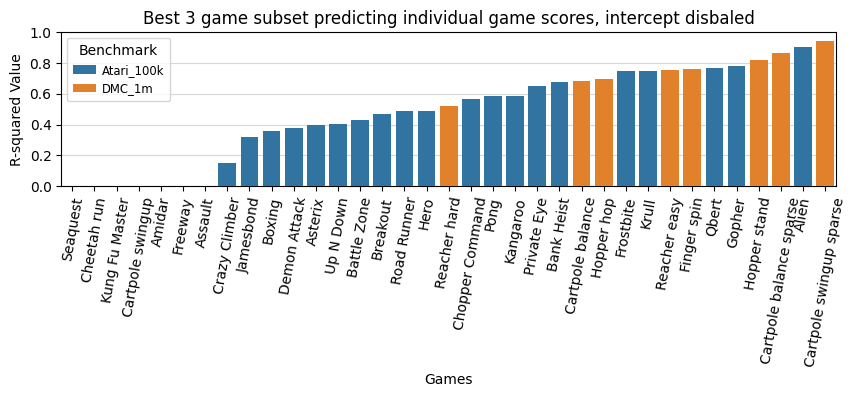

In [16]:
# Regressions
reg_result = []
inercept=False
for game_score in all_games_scores:
    game_reg(df[score_columns], best_subsets[3], game_score, reg_result, inercept)

reg_result_df = pd.DataFrame(reg_result)
reg_result_df_sorted = reg_result_df.sort_values(by='r2', ascending=True)
reg_result_df_sorted = pd.merge(reg_result_df_sorted, df_original[['Environments', 'Benchmark']], on='Environments', how='left')

# Plot r squares
plot_r2_scores(reg_result_df_sorted, "Best 3 game subset predicting individual game scores, intercept disbaled", "eval2_intercept_1")

In [17]:
reg_result_df_sorted

,Environments,r2,Benchmark
0,Seaquest,-5.428782,Atari_100k
1,Cheetah run,-2.484543,DMC_1m
2,Kung Fu Master,-1.169213,Atari_100k
3,Cartpole swingup,-0.556231,DMC_1m
4,Amidar,-0.356898,Atari_100k
5,Freeway,-0.264492,Atari_100k
6,Assault,-0.009755,Atari_100k
7,Crazy Climber,0.149939,Atari_100k
8,Jamesbond,0.321285,Atari_100k
9,Boxing,0.360029,Atari_100k


Intercept set to True

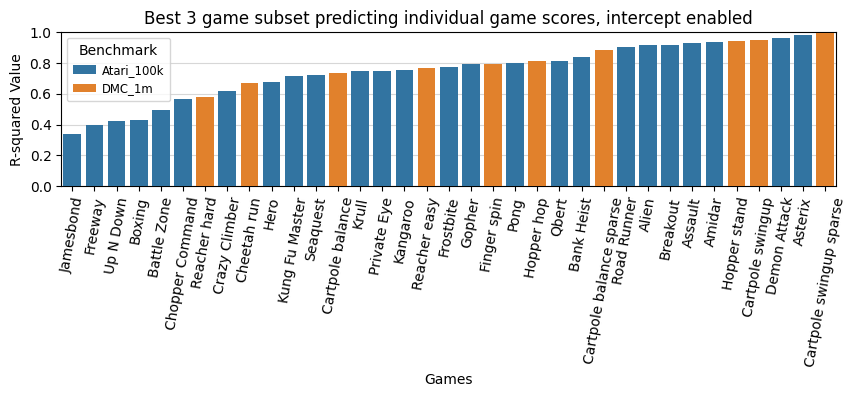

In [18]:
# Regressions
reg_result = []
inercept=True
for game_score in all_games_scores:
    game_reg(df[score_columns], best_subsets[3], game_score, reg_result, inercept)

reg_result_df = pd.DataFrame(reg_result)
reg_result_df_sorted = reg_result_df.sort_values(by='r2', ascending=True)
reg_result_df_sorted = pd.merge(reg_result_df_sorted, df_original[['Environments', 'Benchmark']], on='Environments', how='left')

# Plot r squares
plot_r2_scores(reg_result_df_sorted, "Best 3 game subset predicting individual game scores, intercept enabled", "eval2_intercept_2")

In [19]:
reg_result_df_sorted

,Environments,r2,Benchmark
0,Jamesbond,0.338770,Atari_100k
1,Freeway,0.397158,Atari_100k
2,Up N Down,0.425836,Atari_100k
3,Boxing,0.432482,Atari_100k
4,Battle Zone,0.496734,Atari_100k
5,Chopper Command,0.565000,Atari_100k
6,Reacher hard,0.578207,DMC_1m
7,Crazy Climber,0.615856,Atari_100k
8,Cheetah run,0.672361,DMC_1m
9,Hero,0.678408,Atari_100k


### Case Study

In [20]:
case_study_df = df.loc[best_subsets[3]]#.drop(columns=['Action Space','My PPO','A2C', 'TRPO','R-PPO','Weight'])

In [21]:
envs = case_study_df.index.tolist()

benchmarks = case_study_df['Benchmark'].value_counts().to_dict()
print("\n")
for key, value in benchmarks.items():
    print(f"{key}: {value} envs")
print(f"Work benchmark: {case_study_df.shape[0]} envs\n")
case_study_df['Weight'] = 1 / case_study_df['Benchmark'].map(benchmarks)



DMC_1m: 2 envs
Atari_100k: 1 envs
Work benchmark: 3 envs



In [22]:
case_study_df

,Benchmark,Action Space,My PPO,A2C,TRPO,R-PPO,PPO,CURL,Dreamer,Weight
Ms Pacman,Atari_100k,Discrete,0.947702,1.425051,0.306226,0.516596,0.545300,1.703491,1.723426,1.0
Ball in cup catch,DMC_1m,Continuous,0.992486,0.000000,2.068707,0.000000,2.114984,2.243140,2.244712,0.5
Pendulum swingup,DMC_1m,Continuous,2.019007,0.636867,1.736188,0.374171,0.054364,1.748762,2.000925,0.5


In [23]:
case_study_df = case_study_df.drop(columns=['Benchmark','Action Space','My PPO','A2C', 'TRPO','R-PPO'])

In [24]:
case_study_df

,PPO,CURL,Dreamer,Weight
Ms Pacman,0.545300,1.703491,1.723426,1.0
Ball in cup catch,2.114984,2.243140,2.244712,0.5
Pendulum swingup,0.054364,1.748762,2.000925,0.5


In [25]:
case_study_df.median()

PPO        0.545300
CURL       1.748762
Dreamer    2.000925
Weight     0.500000
dtype: float64

In [26]:
case_study_df.mean()

PPO        0.904883
CURL       1.898464
Dreamer    1.989687
Weight     0.666667
dtype: float64

In [27]:
weighted_median(case_study_df)

PPO        0.545300
CURL       1.703491
Dreamer    1.723426
dtype: float64

In [28]:
weighted_mean(case_study_df)

PPO        0.814987
CURL       1.849721
Dreamer    1.923122
dtype: float64